# Data Requirements
- Please note you will need the data in JSON format from [here](https://github.com/LiyingCheng95/MLMC/tree/main/data/rr-submission-v2) (only `test.json`, `dev.json`).
- We have only provided a sample of the model responses since the full annotations + dataset are 3 GB.
   - Full annotations and data will be released to the link in the paper.
   - The results from NOT running the notebook on your sample data, instead using our 3 GB data from the paper, are below.
- There's a function we call everywhere, `collate` that has been disabled in the code. It is designed to work with your own corpus, in case it comes unordered and with repeated elements.

In [1]:
import json
import numpy as np
from tqdm import tqdm
import re

from sklearn.metrics import f1_score
from scipy.stats import pearsonr

from loading_code_rrv2 import *
from prompt_utils import *
from eval_utils import *
from scoring_utils_am import *
from scoring_utils_ape import *

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
mpl.rcParams['figure.dpi'] = 4*72
plt.style.use('tableau-colorblind10')
%matplotlib inline
import seaborn as sns

TRANSPARENT = "#ffffff00"
default_with_darker_neutral = [
    TRANSPARENT,
    "firebrick",
    "lightcoral",
    "silver",
    "cornflowerblue",
    "darkblue",
]

processed = load_data_instances(json.load(open("test.json", "r", encoding="utf-8")), -1, False)
dev = load_data_instances(json.load(open("dev.json", "r", encoding="utf-8")), -1, False)

# Baselines
Random baselines

In [2]:
print_am_baseline(processed)
print_ape_baseline(processed)

[33.7, 33.46, 33.87, 33.35, 33.22] 33.52 +/- 0.24
[14.84, 14.79, 14.71, 14.82, 14.77] 14.79 +/- 0.04


# AM

## Concrete Scoring

In [19]:
resps_gpt_4_with_start = {
    "32k":{"review": "gpt4_review_with_start_32k.json",
           "response": "gpt4_reply_with_start_32k.json"},
    "16k": {"review": "gpt4_review_with_start_16k.json",
           "response": "gpt4_reply_with_start_16k.json"},
    "8k": {"review": "gpt4_review_with_start_8k.json",
           "response": "gpt4_reply_with_start_8k.json"},
    "4k": {"review": "gpt4_review_with_start.json",
           "response": "gpt4_reply_with_start.json"},
    "0k": {"review": "gpt4_review_with_start_zero_shot.json",
           "response": "gpt4_reply_with_start_zero_shot.json"}
}

resps_gpt_3_with_start = {
    "0k": {"review": "gpt3_review_with_start_zero_shot.json",
           "response": "gpt3_reply_with_start_zero_shot.json"},
    "4k": {"review": "gpt3_review_with_start_4k_new.json",
           "response": "gpt3_reply_with_start_4k_new.json"},
}

resps_gpt_4_cot_with_start = {
    "16k":{"review": "CoT/gpt4_review_cot_with_start_32k.json",
           "response": "CoT/gpt4_reply_cot_with_start_32k.json"},
    "8k": {"review": "CoT/gpt4_review_cot_with_start_8k.json",
           "response": "CoT/gpt4_reply_cot_with_start_8k.json"},
    "4k": {"review": "CoT/gpt4_review_cot_with_start_4k.json",
           "response": "CoT/gpt4_reply_cot_with_start_4k.json"},
    "0k": {"review": "CoT/gpt4_review_cot_with_start_zero_shot.json",
           "response": "CoT/gpt4_reply_cot_with_start_zero_shot.json"}
}


print("GPT-4 (start)")
gpt4_perfs = {}
for k,v in resps_gpt_4_with_start.items():
    print(k, ":")
    gpt4_perfs[k] = print_responses_concrete_am(v["review"], v["response"], processed, collate=False, is_zero_shot="0k" in k)

print("")

print("GPT-4 (start, CoT)")
gpt4_perfs_cot = {}
for k,v in resps_gpt_4_cot_with_start.items():
    print(k, ":")
    gpt4_perfs_cot[k] = print_responses_concrete_am(v["review"], v["response"], processed, collate=False, is_cot=True, is_zero_shot="0k" in k)

print("")

print("GPT-3 (start)")
gpt3_perfs = {}
for k,v in resps_gpt_3_with_start.items():
    print(k, ":")
    gpt3_perfs[k] = print_responses_concrete_am(v["review"], v["response"], processed,  collate=False, is_zero_shot="0k" in k)


GPT-4 (start)
32k :
[59.63, 59.29, 60.22, 60.12, 59.71] 59.79 +/- 0.34
16k :
[60.65, 62.7, 63.5, 62.11, 62.16] 62.22 +/- 0.93
8k :
[64.34, 64.73, 65.01, 64.9, 63.56] 64.51 +/- 0.53
4k :
[51.05, 50.21, 49.46, 50.61, 50.93] 50.45 +/- 0.58
0k :
[35.61, 35.61, 35.63, 35.61, 35.61] 35.61 +/- 0.01

GPT-4 (start, CoT)
16k :
[37.7, 37.62, 37.75, 37.93, 37.57] 37.71 +/- 0.12
8k :
[38.68, 38.41, 38.55, 38.57, 38.54] 38.55 +/- 0.09
4k :
[37.62, 37.68, 37.38, 37.67, 37.63] 37.6 +/- 0.11
0k :
[35.61, 35.61, 35.61, 35.61, 35.61] 35.61 +/- 0.0

GPT-3 (start)
0k :
[36.33, 36.04, 35.87, 36.04, 36.14] 36.08 +/- 0.15
4k :
[40.22, 39.09, 39.4, 40.33, 40.25] 39.86 +/- 0.51


## Symbolic Scoring

In [4]:
resps_gpt4_no_numbers = {
    "32k": {"review": "gpt4_review_symbolic_n4_32k.json",
           "response": "gpt4_reply_symbolic_n4_32k.json"},
    "16k": {"review": "gpt4_review_symbolic_16k.json",
           "response": "gpt4_reply_symbolic_16k.json"},
    "8k": {"review": "gpt4_review_symbolic_8k.json",
           "response": "gpt4_reply_symbolic_8k.json"},
    "4k": {"review": "gpt4_review_symbolic_n4_new.json",
           "response": "gpt4_reply_symbolic_n4_new.json"},
    "0k": {"review": "gpt4_review_symbolic_n4_zero_shot.json",
           "response": "gpt4_reply_symbolic_n4_zero_shot.json"}
}


resps_gpt4_with_numbers = {
    "32k": {"review": "gpt4_review_symbolic_w_numbers_32k.json",
           "response": "gpt4_reply_symbolic_w_numbers_32k.json"},
    "16k": {"review": "gpt4_review_symbolic_w_numbers_16k.json",
           "response": "gpt4_reply_symbolic_w_numbers_16k.json"},
    "8k": {"review": "gpt4_review_symbolic_w_numbers_8k.json",
           "response": "gpt4_reply_symbolic_w_numbers_8k.json"},
    "4k": {"review": "gpt4_review_symbolic_w_numbers_4k.json",
           "response": "gpt4_reply_symbolic_w_numbers_4k.json"},
    "0k": {"review": "gpt4_review_symbolic_w_numbers_zero_shot.json",
           "response": "gpt4_reply_symbolic_w_numbers_zero_shot.json"}
}

resps_gpt4_with_numbers_in_lines = {
    "32k": {"review": "gpt4_review_symbolic_w_numbers_in_lines_32k.json",
           "response": "gpt4_reply_symbolic_w_numbers_in_lines_32k.json"},
    "16k": {"review": "gpt4_review_symbolic_w_numbers_in_lines_16k.json",
           "response": "gpt4_reply_symbolic_w_numbers_in_lines_16k.json"},
    "8k": {"review": "gpt4_review_symbolic_w_numbers_in_lines_8k.json",
           "response": "gpt4_reply_symbolic_w_numbers_in_lines_8k.json"},
    "4k": {"review": "gpt4_review_symbolic_w_numbers_in_lines_4k.json",
           "response": "gpt4_reply_symbolic_w_numbers_in_lines_4k.json"},
    "0k": {"review": "gpt4_review_symbolic_w_numbers_in_lines_zero_shot.json",
           "response": "gpt4_reply_symbolic_w_numbers_in_lines_zero_shot.json"}
}

resps_gpt_4_cot_symbolic = {
    "16k": {"review": "CoT/gpt4_review_symbolic_16k_redone.json",
           "response": "CoT/gpt4_reply_symbolic_16k_redone.json"},
    "8k": {"review": "CoT/gpt4_review_symbolic_8k.json",
           "response": "CoT/gpt4_reply_symbolic_8k.json"},
    "4k": {"review": "CoT/gpt4_review_symbolic_4k.json",
           "response": "CoT/gpt4_reply_symbolic_4k.json"},
    "0k": {"review": "CoT/gpt4_review_symbolic_zero_shot.json",
           "response": "CoT/gpt4_reply_symbolic_zero_shot.json"}
}

resps_gpt_4_cot_symbolic_w_numbers = {
    "16k": {"review": "CoT/gpt4_review_symbolic_w_numbers_16k.json",
           "response": "CoT/gpt4_reply_symbolic_w_numbers_16k_corrected.json"},
    "8k": {"review": "CoT/gpt4_review_symbolic_w_numbers_8k.json",
           "response": "CoT/gpt4_reply_symbolic_w_numbers_8k.json"},
    "4k": {"review": "CoT/gpt4_review_symbolic_w_numbers_4k.json",
           "response": "CoT/gpt4_reply_symbolic_w_numbers_4k.json"},
    "0k": {"review": "CoT/gpt4_review_symbolic_w_numbers_zero_shot.json",
           "response": "CoT/gpt4_reply_symbolic_w_numbers_zero_shot.json"}
}

resps_gpt_4_cot_symbolic_w_numbers_in_lines = {
    "16k": {"review": "CoT/gpt4_review_symbolic_w_numbers_in_lines_16k.json",
           "response": "CoT/gpt4_reply_symbolic_w_numbers_in_lines_16k.json"},
    "8k": {"review": "CoT/gpt4_review_symbolic_w_numbers_in_lines_8k.json",
           "response": "CoT/gpt4_reply_symbolic_w_numbers_in_lines_8k.json"},
    "4k": {"review": "CoT/gpt4_review_symbolic_w_numbers_in_lines_4k.json",
           "response": "CoT/gpt4_reply_symbolic_w_numbers_in_lines_4k.json"},
    "0k": {"review": "CoT/gpt4_review_symbolic_w_numbers_in_lines_zero_shot.json",
           "response": "CoT/gpt4_reply_symbolic_w_numbers_in_lines_zero_shot.json"}
}

resps_gpt3_no_numbers = {
    "4k": {"review": "gpt3_review_symbolic_n4_new.json",
           "response": "gpt3_reply_symbolic_n4_new.json"},
    "0k": {"review": "gpt3_review_symbolic_zero_shot.json",
           "response": "gpt3_reply_symbolic_zero_shot.json"},
}

resps_gpt3_numbers = {
    "4k": {"review": "gpt3_review_symbolic_w_numbers_4k.json",
           "response": "gpt3_reply_symbolic_w_numbers_4k.json"},
    "0k": {"review": "gpt3_review_symbolic_w_numbers_zero_shot.json",
           "response": "gpt3_reply_symbolic_w_numbers_zero_shot.json"}
}

resps_gpt3_inline = {
    "4k": {"review": "gpt3_review_symbolic_w_numbers_in_lines_4k.json",
           "response": "gpt3_reply_symbolic_w_numbers_in_lines_4k.json"},
    "0k": {"review": "gpt3_review_symbolic_w_numbers_in_lines_zero_shot.json",
           "response": "gpt3_reply_symbolic_w_numbers_in_lines_zero_shot.json"}
}

print("GPT-4 (no numbers)")
gpt4_perfs_no_numbers = {}
for k,v in resps_gpt4_no_numbers.items():
    print(k, ":")
    gpt4_perfs_no_numbers[k] = print_responses_symbolic_am(v["review"], v["response"], processed, collate=False)

print("")

print("GPT-4 (numbers)")
gpt4_perfs_numbers = {}
for k,v in resps_gpt4_with_numbers.items():
    print(k, ":")
    gpt4_perfs_numbers[k] = print_responses_symbolic_am(v["review"], v["response"], processed,collate=False, is_numbers=True)

print("")

print("GPT-4 (numbers inline)")
gpt4_perfs_numbers_inline = {}
for k,v in resps_gpt4_with_numbers_in_lines.items():
    print(k, ":")
    gpt4_perfs_numbers_inline[k] = print_responses_symbolic_am(v["review"], v["response"], processed, collate=False, is_numbers=True, is_inline=True)


print("")

print("GPT-4 (symbols) (CoT)")
gpt4_perfs_symbols_cot = {}
for k,v in resps_gpt_4_cot_symbolic.items():
    print(k, ":")
    gpt4_perfs_symbols_cot[k] = print_responses_symbolic_am(v["review"], v["response"],  processed,collate=False, is_cot=True, symbols=True, is_zero_shot="0" in k)

    
print("")

print("GPT-4 (numbers) (CoT)")
gpt4_perfs_numbers_cot = {}
for k,v in resps_gpt_4_cot_symbolic_w_numbers.items():
    print(k, ":")
    gpt4_perfs_numbers_cot[k] = print_responses_symbolic_am(v["review"], v["response"],  processed,collate=False, is_cot=True, symbols=False, is_zero_shot="0" in k)

    
print("")

print("GPT-4 (numbers inline) (CoT)")
gpt4_perfs_numbers_inline_cot = {}
for k,v in resps_gpt_4_cot_symbolic_w_numbers_in_lines.items():
    print(k, ":")
    gpt4_perfs_numbers_inline_cot[k] = print_responses_symbolic_am(v["review"], v["response"],  processed,collate=False, is_cot=True, symbols=False, is_zero_shot="0" in k)

print("")
print("------")
print("")

print("GPT-3 (no numbers)")
gpt3_perfs_no_numbers = {}
for k,v in resps_gpt3_no_numbers.items():
    print(k, ":")
    gpt3_perfs_no_numbers[k] = print_responses_symbolic_am(v["review"], v["response"],  processed,collate=False)

print("")

print("GPT-3 (numbers)")
gpt3_perfs_numbers = {}
for k,v in resps_gpt3_numbers.items():
    print(k, ":")
    gpt3_perfs_numbers[k] = print_responses_symbolic_am(v["review"], v["response"],  processed,collate=False, is_numbers=True)

print("")


print("GPT-3 (inline)")
gpt3_perfs_inline = {}
for k,v in resps_gpt3_inline.items():
    print(k, ":")
    gpt3_perfs_inline[k] = print_responses_symbolic_am(v["review"], v["response"],  processed,collate=False, is_numbers=True, is_inline=True, is_zero_shot="0" in k)

print("")

GPT-4 (no numbers)
32k :
[47.06, 48.9, 48.0, 48.11, 47.56] 47.93 +/- 0.61
16k :
[51.28, 51.65, 51.08, 51.06, 51.88] 51.39 +/- 0.32
8k :
[51.9, 52.01, 52.58, 52.13, 52.63] 52.25 +/- 0.3
4k :
[55.4, 54.64, 55.45, 55.19, 55.81] 55.3 +/- 0.38
0k :
[35.14, 35.2, 35.25, 34.86, 35.32] 35.15 +/- 0.16

GPT-4 (numbers)
32k :
[41.74, 41.21, 41.7, 41.39, 40.6] 41.33 +/- 0.41
16k :
[47.33, 47.34, 47.65, 47.2, 46.47] 47.2 +/- 0.39
8k :
[49.21, 48.79, 49.66, 49.65, 48.93] 49.25 +/- 0.36
4k :
[50.39, 50.37, 49.58, 50.02, 50.22] 50.12 +/- 0.3
0k :
[41.18, 40.97, 40.21, 40.12, 40.71] 40.64 +/- 0.41

GPT-4 (numbers inline)
32k :
[56.05, 54.69, 54.94, 55.74, 55.48] 55.38 +/- 0.5
16k :
[64.66, 64.91, 64.73, 64.46, 64.07] 64.57 +/- 0.29
8k :
[70.68, 70.77, 70.93, 70.36, 70.43] 70.63 +/- 0.21
4k :
[66.97, 67.16, 67.22, 66.43, 66.6] 66.88 +/- 0.31
0k :
[36.54, 35.44, 36.2, 34.95, 35.05] 35.64 +/- 0.63

GPT-4 (symbols) (CoT)
16k :
[65.31, 65.89, 65.34, 65.22, 65.37] 65.43 +/- 0.24
8k :
[65.38, 65.13, 65.57, 64

## AMR Scoring

In [8]:
resps_amr_gpt_4 = {
    "32k": {"review": "gpt4_review_amr_w_context_32k.json",
           "response": "gpt4_response_amr_w_context_32k.json"},
    "4k": {"review": "gpt4_review_amr_w_context_4k.json",
           "response": "gpt4_response_amr_w_context_4k.json"},
    "0k": {"review": "gpt4_review_amr_w_context_zero_shot.json",
           "response": "gpt4_response_amr_w_context_zero_shot.json"}
}

resps_amr_no_context_gpt_4 = {
    "32k": {"review": "gpt4_review_amr_no_context_32k.json",
           "response": "gpt4_response_amr_no_context_32k.json"},
    "4k": {"review": "gpt4_review_amr_no_context_4k.json",
           "response": "gpt4_response_amr_no_context_4k.json"},
    "0k": {"review": "gpt4_review_amr_no_context_zero_shot.json",
           "response": "gpt4_response_amr_no_context_zero_shot.json"}
}

print("GPT-4")
gpt4_perfs_amr_context = {}
for k,v in resps_amr_gpt_4.items():
    print(k, ":")
    gpt4_perfs_amr_context[k] = print_responses_amr(v["review"], v["response"], processed, collate=False)

print("")

print("GPT-4 (no context)")
gpt4_perfs_amr_no_context = {}
for k,v in resps_amr_no_context_gpt_4.items():
    print(k, ":")
    gpt4_perfs_amr_no_context[k] = print_responses_amr(v["review"], v["response"], processed, collate=False)


GPT-4
32k :
[46.97, 46.54, 46.79, 46.95, 47.0] 46.85 +/- 0.17
4k :
[46.74, 47.21, 46.89, 47.32, 47.51] 47.13 +/- 0.28
0k :
[35.7, 35.67, 35.55, 35.67, 35.66] 35.65 +/- 0.05

GPT-4 (no context)
32k :
[48.09, 48.23, 46.97, 48.49, 48.14] 47.98 +/- 0.53
4k :
[44.44, 46.03, 45.47, 45.38, 45.01] 45.27 +/- 0.53
0k :
[35.67, 35.6, 35.56, 35.6, 35.66] 35.62 +/- 0.04


## Plots (AM)

We run this cell to get the average number of shots used, because it is not consistent for the last ("16k/32k") set that uses all the available tokens. 
Note that we need to factor in the anchors in the shots

In [20]:
print("GPT-4 (no numbers)")
for k,v in resps_gpt4_no_numbers.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("GPT-4 (numbers)")
for k,v in resps_gpt4_with_numbers.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("GPT-4 (inline)")
for k,v in resps_gpt4_with_numbers_in_lines.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))

print("")
print("------")
print("")

print("GPT-4 (CoT; no numbers)")
for k,v in resps_gpt_4_cot_symbolic.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed, suffix=""))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("GPT-4 (CoT; numbers)")
for k,v in resps_gpt_4_cot_symbolic_w_numbers.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed, suffix=""))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("GPT-4 (CoT; inline)")
for k,v in resps_gpt_4_cot_symbolic_w_numbers_in_lines.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed, suffix=""))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("GPT-4 (CoT; text)")
for k,v in resps_gpt_4_cot_with_start.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed, suffix=""))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))

print("")
print("------")
print("")


print("GPT-4 AMR (context)")
for k,v in resps_amr_gpt_4.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("GPT-4 AMR (no context)")
for k,v in resps_amr_no_context_gpt_4.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))

print("")
print("------")
print("")


print("GPT-3 (no numbers)")
for k,v in resps_gpt3_no_numbers.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))

print("GPT-3 (inline)")
for k,v in resps_gpt3_inline.items():
    exs = np.array(get_example_sizes_am(v["review"], v["response"], processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))


GPT-4 (no numbers)
32k : 43 49 43
16k : 16 22 16
8k : 8 14 8
4k : 3 10 4
0k : 0 6 0
GPT-4 (numbers)
32k : 45 51 46
16k : 17 23 17
8k : 9 15 9
4k : 5 11 5
0k : 1 7 1
GPT-4 (inline)
32k : 40 47 41
16k : 17 23 17
8k : 9 15 9
4k : 5 11 5
0k : 1 7 1

------

GPT-4 (CoT; no numbers)
16k : 16 23 17
8k : 9 15 9
4k : 5 11 5
0k : 1 7 1
GPT-4 (CoT; numbers)
16k : 14 22 16
8k : 9 15 9
4k : 5 11 5
0k : 1 7 1
GPT-4 (CoT; inline)
16k : 13 21 15
8k : 9 15 9
4k : 5 11 5
0k : 1 7 1
GPT-4 (CoT; text)
16k : 14 20 15
8k : 9 15 9
4k : 5 11 5
0k : 1 7 1

------

GPT-4 AMR (context)
32k : 6 15 9
4k : 5 11 5
0k : 1 7 1
GPT-4 AMR (no context)
32k : 9 11 10
4k : 5 5 5
0k : 1 1 1

------

GPT-3 (no numbers)
4k : 1 8 3
0k : 0 6 0
GPT-3 (inline)
4k : 2 10 5
0k : 1 7 1


## Plots (Abstraction)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


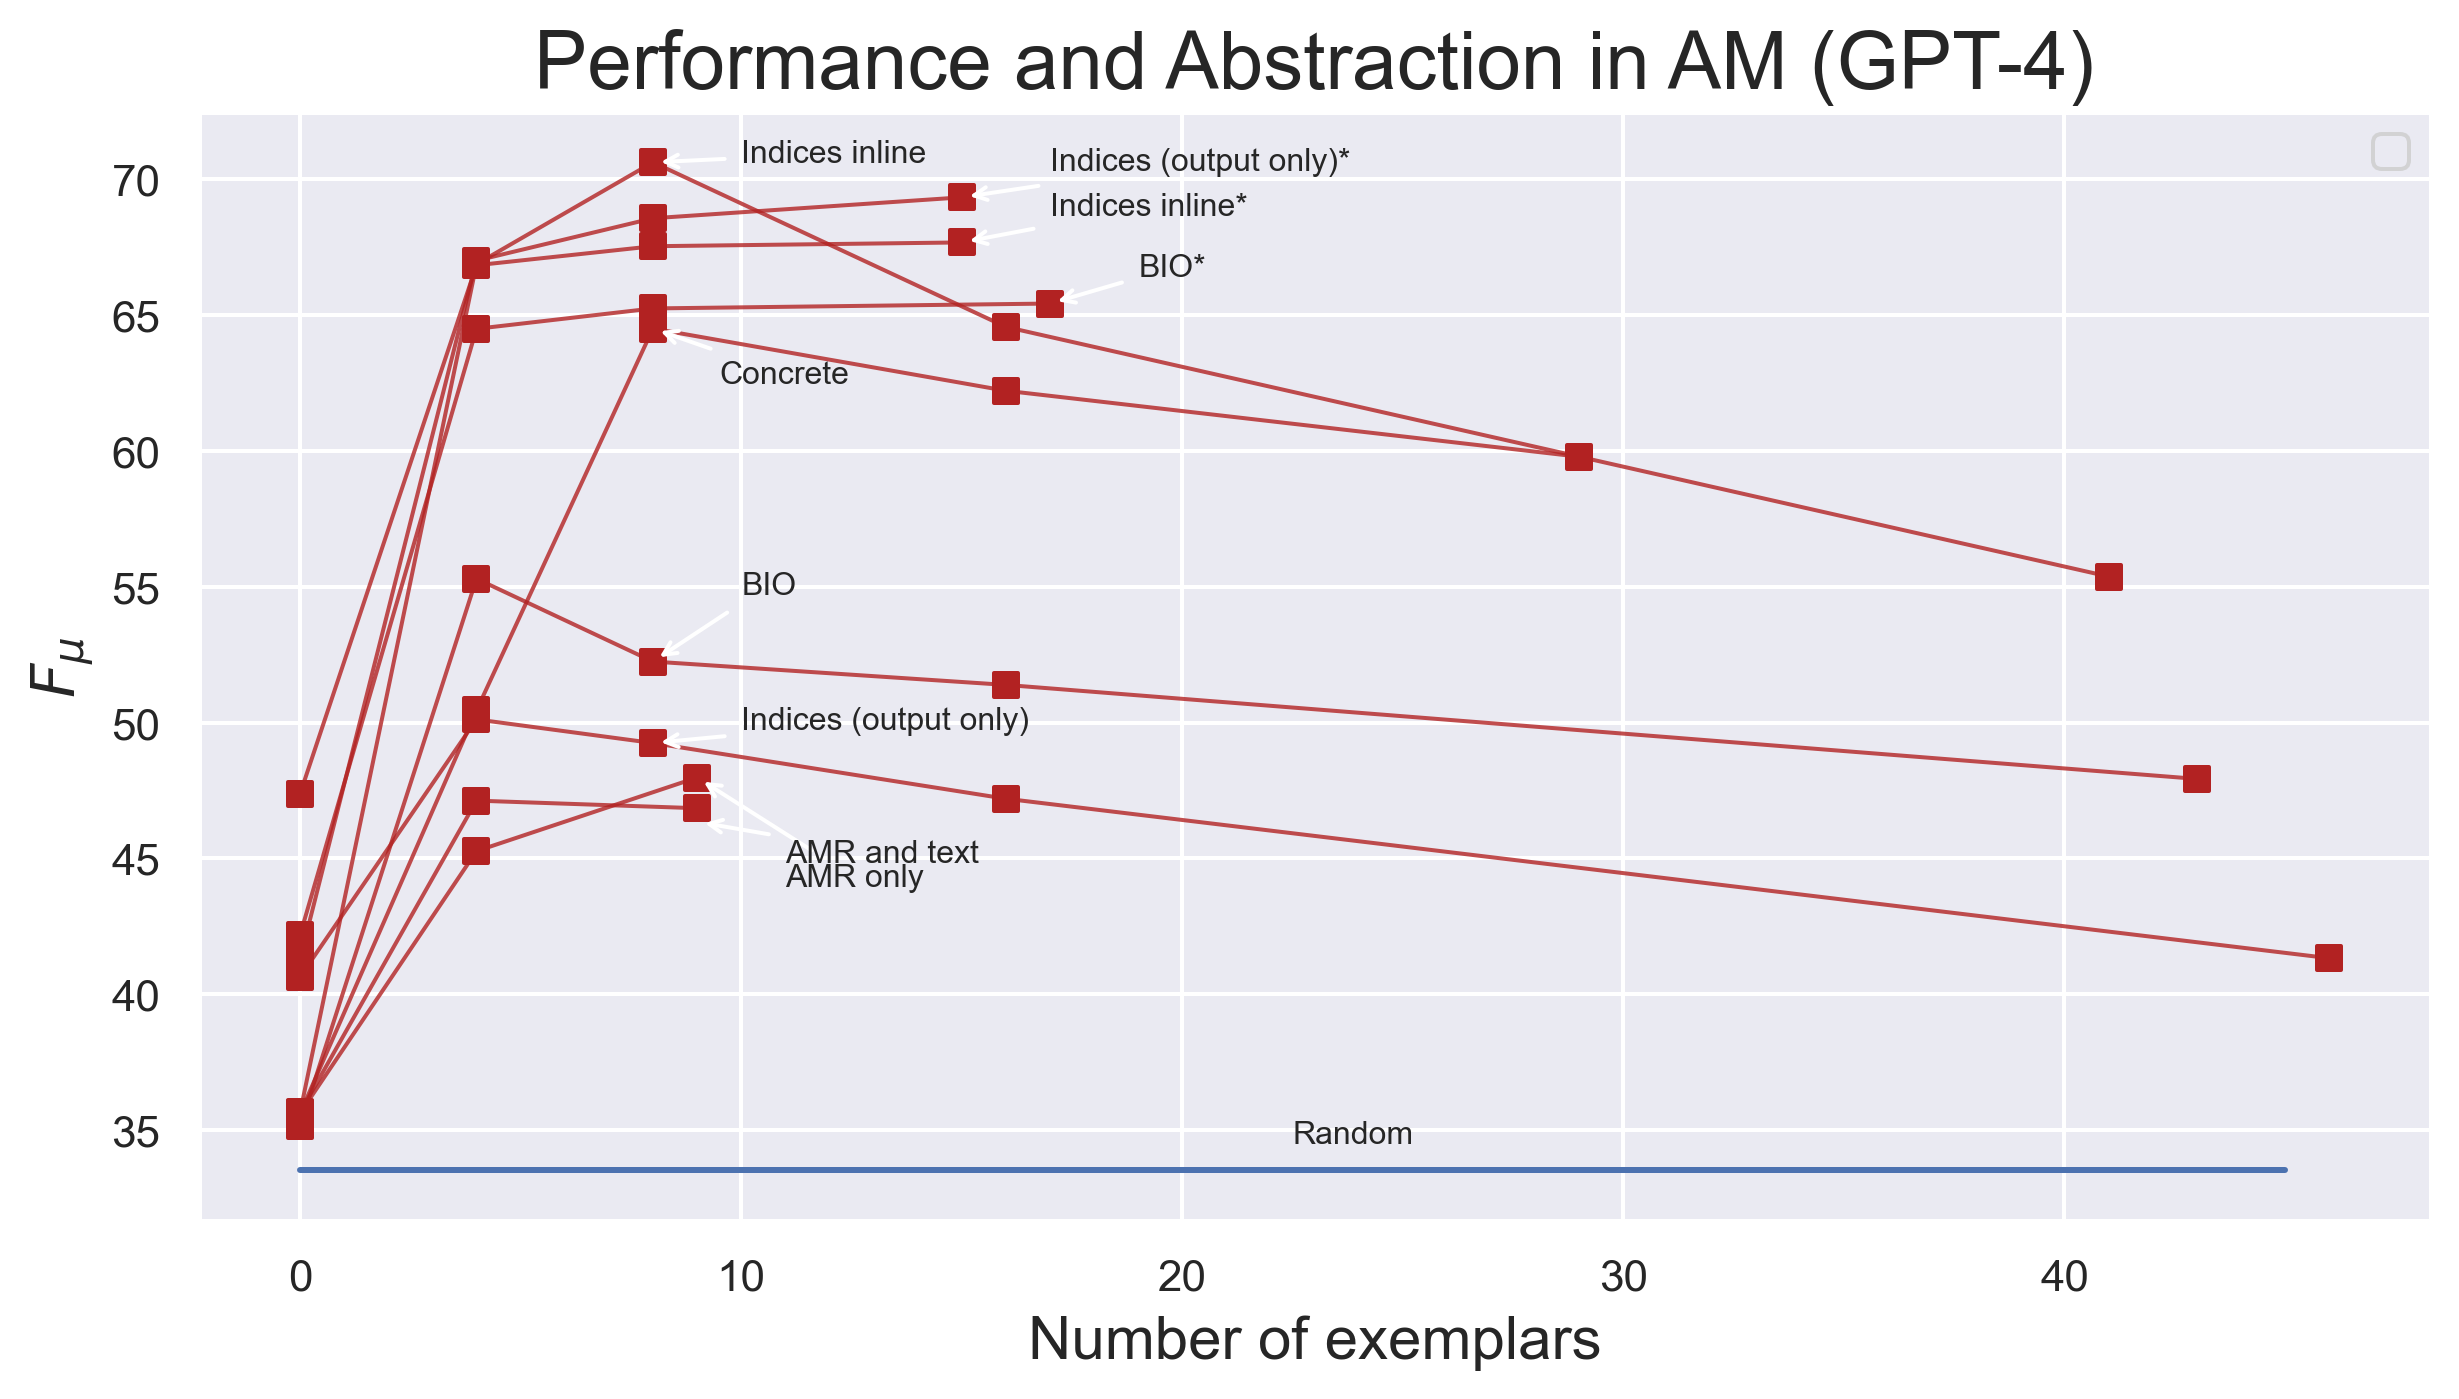

In [10]:
sns.set_theme()

mean = lambda x: sum(x)/len(x)
mean10 = lambda x: sum(x)/len(x) + 10

fig = plt.figure(figsize = (10, 5))

x = [0, 4, 8, 16, 23]
xkeys = ["0k", "4k", "8k", "16k", "32k"]
ix = 1
base_width = 1
base_alpha = 0.8
avg_weight = 3
avg_alpha = 1.

ix_concrete = 4
ix_symbolic = 1
ix_amr = 2

arr_props = dict(facecolor='black', arrowstyle = '->', linewidth=1)

x = [0, 4, 8, 16, 29]
plt.scatter(x, [gpt4_perfs[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [gpt4_perfs[i][0] for i in xkeys],linewidth=base_width, alpha=base_alpha,
          color=default_with_darker_neutral[ix_symbolic]) #, label="0")
plt.annotate("Concrete", xy=(x[2], [gpt4_perfs[i][0] for i in xkeys][2]),
             xytext=(x[2] + 1.5, [gpt4_perfs[i][0] for i in xkeys][2] - 2),
             xycoords='data',
             arrowprops=arr_props, fontsize=8)


x = [0, 4, 8, 16, 43]
# label="Symbolic (no numbers; GPT-4)",
plt.scatter(x, [gpt4_perfs_no_numbers[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [gpt4_perfs_no_numbers[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width, color=default_with_darker_neutral[ix_symbolic]) #, label="4")
plt.annotate("BIO", xy=(x[2], [gpt4_perfs_no_numbers[i][0] for i in xkeys][2]), 
             xytext=(x[2] + 2, [gpt4_perfs_no_numbers[i][0] for i in xkeys][2] + 2.5),
             xycoords='data',
             arrowprops=arr_props, fontsize=8)

#ix += 1

x = [0, 4, 8, 16, 46]
# label="Symbolic (w/ numbers; GPT-4)",
plt.scatter(x, [gpt4_perfs_numbers[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [gpt4_perfs_numbers[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width, color=default_with_darker_neutral[ix_symbolic]) #, label="3")
plt.annotate("Indices (output only)", xy=(x[2], [gpt4_perfs_numbers[i][0] for i in xkeys][2]), 
             xytext=(x[2] + 2, [gpt4_perfs_numbers[i][0] for i in xkeys][2] + 0.5),
             xycoords='data',
             arrowprops=arr_props, fontsize=8)


#ix += 1

x = [0, 4, 8, 16, 41]
# label="Symbolic (inline; GPT-4)",
plt.scatter(x, [gpt4_perfs_numbers_inline[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [gpt4_perfs_numbers_inline[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width, color=default_with_darker_neutral[ix_symbolic]) #, label="2")
plt.annotate("Indices inline", xy=(x[2], [gpt4_perfs_numbers_inline[i][0] for i in xkeys][2]), 
             xytext=(x[2] + 2, [gpt4_perfs_numbers_inline[i][0] for i in xkeys][2] + 0),
             xycoords='data',
             arrowprops=arr_props, fontsize=8)

#ix += 1

# COT------------------------
x = [0, 4, 8, 17]
xkeys = ["0k", "4k", "8k", "16k"]
# label="Symbolic (no numbers; COT GPT-4)",
plt.scatter(x, [gpt4_perfs_symbols_cot[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [gpt4_perfs_symbols_cot[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width,  color=default_with_darker_neutral[ix_symbolic])
#ix += 1
plt.annotate("BIO*", xy=(x[-1], [gpt4_perfs_symbols_cot[i][0] for i in xkeys][-1]), 
             xytext=(x[-1] +2, [gpt4_perfs_symbols_cot[i][0] for i in xkeys][-1] + 1),
             xycoords='data',
             arrowprops=arr_props, fontsize=8)


# label="Symbolic (w/ numbers; COT GPT-4)",
x = [0, 4, 8, 15]
plt.scatter(x, [gpt4_perfs_numbers_cot[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [gpt4_perfs_numbers_cot[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width,  color=default_with_darker_neutral[ix_symbolic])
plt.annotate("Indices (output only)*", xy=(x[-1], [gpt4_perfs_numbers_cot[i][0] for i in xkeys][-1]), 
             xytext=(x[-1] + 2, [gpt4_perfs_numbers_cot[i][0] for i in xkeys][-1] + 1),
             xycoords='data',
             arrowprops=arr_props, fontsize=8)

#ix += 1

x = [0, 4, 8, 15]
# label="Symbolic (inline; COT GPT-4)",
plt.scatter(x, [gpt4_perfs_numbers_inline_cot[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [gpt4_perfs_numbers_inline_cot[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width,  color=default_with_darker_neutral[ix_symbolic])
plt.annotate("Indices inline*", xy=(x[-1], [gpt4_perfs_numbers_inline_cot[i][0] for i in xkeys][-1]), 
             xytext=(x[-1] +2, [gpt4_perfs_numbers_inline_cot[i][0] for i in xkeys][-1] + 1),
             xycoords='data',
             arrowprops=arr_props, fontsize=8)



# AMR -------------------------------
xkeys = ["0k", "4k", "32k"]
x = [0, 4, 9]
plt.scatter(x, [gpt4_perfs_amr_no_context[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [gpt4_perfs_amr_no_context[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width, color=default_with_darker_neutral[ix_symbolic]) #, label="5")
plt.annotate("AMR only", xy=(x[2], [gpt4_perfs_amr_no_context[i][0] for i in xkeys][2]), 
             xytext=(x[2] + 2, [gpt4_perfs_amr_no_context[i][0] for i in xkeys][2] - 4),
             xycoords='data',
             arrowprops=arr_props, fontsize=8)


#ix += 1

x = [0, 4, 9]
plt.scatter(x, [gpt4_perfs_amr_context[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [gpt4_perfs_amr_context[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width, color=default_with_darker_neutral[ix_symbolic])
plt.annotate("AMR and text", xy=(x[2], [gpt4_perfs_amr_context[i][0] for i in xkeys][2] - 0.5), 
             xytext=(x[2] + 2, [gpt4_perfs_amr_context[i][0] for i in xkeys][2] - 2),
             xycoords='data',
             arrowprops=arr_props, fontsize=8)

#ix += 1

plt.plot([i for i in range(46)], [33.52 for _ in range(46)])
plt.annotate("Random", xy=(mean([i for i in range(46)]), mean([33.52 for _ in range(46)]) + 1.), xycoords='data',
            fontsize=8)


plt.rc('text', usetex=True)

plt.title("Performance and Abstraction in AM (GPT-4)", fontsize=20)
plt.xlabel("Number of exemplars", fontsize=15)
plt.ylabel("$F_{\mu}$", fontsize=15)

plt.legend()
plt.show()

# CI Calculation

- It is kind of nasty but allows us to have a very, very broad bird's eye on the performances.
- Run this _after_ running everything else in AM. This will only print the elements where:
   - (a) we compare 1:1 number of shots (16 shots to 16 shots, e.g.)
   - (b) p > 0.05
- Be patient! This is going over around 474 points 5 times on ~ 5 tests on 9 elements of the array. That's like 106k points!

In [11]:
from scipy import stats

arr_with_preds = [("Concrete", gpt4_perfs),
                  ("Symbolic (Int/Int)", gpt4_perfs_numbers_inline),
                  ("Symbolic (Int)", gpt4_perfs_numbers),
                  ("Symbolic (BIO)", gpt4_perfs_no_numbers),
                  ("Symbolic* (Int/Int)", gpt4_perfs_numbers_inline_cot),
                  ("Symbolic* (Int)", gpt4_perfs_numbers_cot),
                  ("Symbolic* (BIO)", gpt4_perfs_symbols_cot),
                  ("AMR (context)", gpt4_perfs_amr_context),
                  ("AMR (no context)", gpt4_perfs_amr_no_context),]

results = {}

for name1, entry1 in tqdm(arr_with_preds):
    for k1, res in entry1.items():
        predictions1 = res[-1]["predictions"][0] # Let's do the last one for now
        ground_truth = res[-1]["actuals"][0]
        for name2, entry2 in arr_with_preds:
            for k2, res2 in entry2.items():
                predictions2 = res2[-1]["predictions"][0]
                experiment_key = "{}_{}".format(name1, k1)
                experiment_key2 = "{}_{}".format(name2, k2, equal_var=False)
                stat = stats.ttest_ind([a == b for a,b in zip(predictions1, ground_truth)], [a == b for a,b in zip(predictions2, ground_truth)])                
                if name1 != name2 and k1 == k2 and "Concrete" not in name1 and "Concrete" not in name2:
                    if stat.pvalue > 0.05:
                        print(name1, name2, k2, round(stat.statistic, 2), round(stat.pvalue, 2), stat.confidence_interval(confidence_level=0.95))
                if experiment_key not in results:
                    results[experiment_key] = {}
                results[experiment_key][experiment_key2] = stat


 11%|█████████▎                                                                          | 1/9 [01:26<11:31, 86.39s/it]

Symbolic (Int/Int) Symbolic* (BIO) 16k -1.42 0.15 ConfidenceInterval(low=-0.01531902874392357, high=0.0024320824094939096)
Symbolic (Int/Int) Symbolic* (Int/Int) 4k 0.86 0.39 ConfidenceInterval(low=-0.004934132143010821, high=0.012594205139000518)
Symbolic (Int/Int) Symbolic* (Int) 4k 0.84 0.4 ConfidenceInterval(low=-0.005023955362891417, high=0.012503791347210755)
Symbolic (Int/Int) AMR (context) 0k 1.86 0.06 ConfidenceInterval(low=-0.00046633538770555344, high=0.017408614484718178)


 22%|██████████████████▋                                                                 | 2/9 [02:51<10:00, 85.74s/it]

Symbolic (Int/Int) AMR (no context) 0k 1.91 0.06 ConfidenceInterval(low=-0.00024041441239596936, high=0.01763328603858438)


 33%|████████████████████████████                                                        | 3/9 [04:15<08:30, 85.07s/it]

Symbolic (BIO) AMR (context) 32k 0.18 0.86 ConfidenceInterval(low=-0.008430807380142716, high=0.010143058991011015)
Symbolic (BIO) AMR (context) 0k -1.22 0.22 ConfidenceInterval(low=-0.014441252487747048, high=0.0033566762700207534)


 44%|█████████████████████████████████████▎                                              | 4/9 [05:41<07:06, 85.35s/it]

Symbolic (BIO) AMR (no context) 0k -1.17 0.24 ConfidenceInterval(low=-0.01421532880879132, high=0.0035813451202408118)
Symbolic* (Int/Int) Symbolic (Int/Int) 4k -0.86 0.39 ConfidenceInterval(low=-0.012594205139000518, high=0.004934132143010821)
Symbolic* (Int/Int) Symbolic* (Int) 4k -0.02 0.98 ConfidenceInterval(low=-0.008866674018573793, high=0.008686437006903434)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [07:16<05:55, 88.87s/it]

Symbolic* (Int) Symbolic (Int/Int) 4k -0.84 0.4 ConfidenceInterval(low=-0.012503791347210755, high=0.005023955362891417)
Symbolic* (Int) Symbolic* (Int/Int) 4k 0.02 0.98 ConfidenceInterval(low=-0.008686437006903434, high=0.008866674018573793)
Symbolic* (Int) Symbolic* (BIO) 0k 0.29 0.77 ConfidenceInterval(low=-0.007838685196787576, high=0.010542240371842848)


 67%|████████████████████████████████████████████████████████                            | 6/9 [08:29<04:09, 83.27s/it]

Symbolic* (BIO) Symbolic (Int/Int) 16k 1.42 0.15 ConfidenceInterval(low=-0.0024320824094939096, high=0.01531902874392357)
Symbolic* (BIO) Symbolic* (Int) 0k -0.29 0.77 ConfidenceInterval(low=-0.010542240371842848, high=0.007838685196787576)


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [09:37<02:36, 78.37s/it]

AMR (context) Symbolic (BIO) 32k -0.18 0.86 ConfidenceInterval(low=-0.010143058991011015, high=0.008430807380142716)
AMR (context) Symbolic (Int/Int) 0k -1.86 0.06 ConfidenceInterval(low=-0.017408614484718178, high=0.00046633538770555344)
AMR (context) Symbolic (BIO) 0k 1.22 0.22 ConfidenceInterval(low=-0.0033566762700207534, high=0.014441252487747048)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [10:25<01:08, 68.79s/it]

AMR (context) AMR (no context) 0k 0.05 0.96 ConfidenceInterval(low=-0.008688748415453116, high=0.009139340944628902)
AMR (no context) Symbolic (Int/Int) 0k -1.91 0.06 ConfidenceInterval(low=-0.01763328603858438, high=0.00024041441239596936)
AMR (no context) Symbolic (BIO) 0k 1.17 0.24 ConfidenceInterval(low=-0.0035813451202408118, high=0.01421532880879132)
AMR (no context) AMR (context) 0k -0.05 0.96 ConfidenceInterval(low=-0.009139340944628902, high=0.008688748415453116)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [11:05<00:00, 73.94s/it]


# APE

## Concrete Scoring

In [12]:
resps_with_start_gpt_4 = {
    "32k": "gpt4_ape_concrete_with_start32k.json",
    "8k": "gpt4_ape_concrete_with_start_8k.json",
    "4k": "gpt4_ape_concrete_with_start_4k_new.json",
    "0k": "gpt4_ape_concrete_with_start_0_shot_new.json"
}

resps_with_start_gpt_3 = {
    "4k": "gpt3_ape_concrete_with_start.json",
    "0k": "gpt3_ape_concrete_with_start_zero_shot_new.json"
}

resps_without_start_gpt_4 = {
    "4k": "gpt4_ape_concrete.json",
}

resps_without_start_gpt_3 = {
    "4k": "gpt4_ape_concrete.json",
}


print("GPT-4 (start)")
results_gpt4_ape_start = {}
for k,v in resps_with_start_gpt_4.items():
    print(k, ":")
    results_gpt4_ape_start[k] = print_responses_ape_concrete(v, processed, collate=False, is_zero_shot=("0_shot" in k))

print("")
    
print("GPT-3 (start)")
results_gpt3_ape_start = {}
for k,v in resps_with_start_gpt_3.items():
    print(k, ":")
    results_gpt3_ape_start[k] = print_responses_ape_concrete(v, processed, collate=False, is_zero_shot=("zero_shot" in k))

GPT-4 (start)
32k :
[31.59, 28.07, 34.12, 31.04, 31.79] 31.32 +/- 1.94
8k :
[49.62, 52.33, 50.64, 51.47, 51.9] 51.19 +/- 0.96
4k :
[54.11, 54.27, 54.14, 54.31, 52.39] 53.84 +/- 0.73
0k :
[22.38, 17.82, 20.21, 19.06, 19.45] 19.78 +/- 1.51

GPT-3 (start)
4k :
[19.72, 17.73, 18.41, 18.07, 18.97] 18.58 +/- 0.7
0k :
[0.8, 0.78, 0.88, 0.75, 0.6] 0.76 +/- 0.09


## Symbolic Scoring

In [13]:
resps_symbolic_gpt_4_full = {
    "32k": "gpt4_ape_symbolic_full_16k.json",
    "4k": "gpt4_ape_symbolic_full_4k_new.json",
    "0k": "gpt4_ape_symbolic_full_zero_shot_new.json"
}


resps_symbolic_gpt_4 = {
    "32k": "gpt4_ape_symbolic_32k_not8_samples.json",
    "4k": "gpt4_ape_symbolic.json",
    "0k": "gpt4_ape_symbolic_zeroshot_new_new.json"
}

resps_symbolic_gpt_3 = {
    "4k": "gpt3_ape_symbolic.json",
    "0k": "gpt3_ape_symbolic_zeroshot_new.json",
}

resps_symbolic_numbers_gpt_4 = {
    "32k": "gpt4_ape_symbolic_w_numbers_32k.json",
    "4k": "gpt4_ape_symbolic_w_numbers_4k.json",
    "0k": "gpt4_ape_symbolic_w_numbers_zero_shot_new.json"
}

resps_symbolic_gpt_3_full = {
    "4k": "gpt3_ape_symbolic_full_4k.json",
    "0k": "gpt3_ape_symbolic_full_zero_shot.json"
}

resps_symbolic_numbers_gpt_3 = {
    "4k": "gpt3_symbolic_w_numbers_4k.json",
    "0k": "gpt3_ape_symbolic_numbers_zeroshot.json",
}


print("GPT-4 (full)")
results_gpt4_ape_symbolic_full = {}
for k,v in resps_symbolic_gpt_4_full.items():
    print(k, ":")
    results_gpt4_ape_symbolic_full[k] = print_responses_ape_symbolic(v, processed,collate=False, is_full=True, is_zero_shot=("zero" in k))
print("")


print("GPT-4 (no numbers)")
results_gpt4_ape_symbolic_no_numbers = {}
for k,v in resps_symbolic_gpt_4.items():
    print(k, ":")
    results_gpt4_ape_symbolic_no_numbers[k] = print_responses_ape_symbolic(v,processed, collate=False, is_zero_shot=("zero" in k))
print("")

print("GPT-4 (numbers)")
results_gpt4_ape_symbolic_numbers = {}
for k,v in resps_symbolic_numbers_gpt_4.items():
    print(k, ":")
    results_gpt4_ape_symbolic_numbers[k] = print_responses_ape_symbolic(v,processed, collate=False, is_zero_shot=("zero" in k), is_numbers=True)
print("")

print("----------------")
results_gpt3_ape_symbolic_no_numbers = {}
print("GPT-3 (no numbers)")
for k,v in resps_symbolic_gpt_3.items():
    print(k, ":")
    results_gpt3_ape_symbolic_no_numbers[k] = print_responses_ape_symbolic(v, processed, collate=False, is_zero_shot=("zero" in k))
print("")

print("GPT-3 (numbers)")
results_gpt3_ape_symbolic_numbers = {}
for k,v in resps_symbolic_numbers_gpt_3.items():
    print(k, ":")
    results_gpt3_ape_symbolic_numbers[k] = print_responses_ape_symbolic(v, processed, collate=False, is_zero_shot=("zero" in k), is_numbers=True)


GPT-4 (full)
32k :
[2.1, 1.84, 2.96, 2.26, 2.33] 2.3 +/- 0.37
4k :
[10.51, 9.9, 9.51, 9.87, 9.63] 9.88 +/- 0.35
0k :
[2.71, 2.52, 3.07, 2.81, 2.43] 2.71 +/- 0.23

GPT-4 (no numbers)
32k :
[10.47, 10.58, 12.31, 11.85, 9.25] 10.89 +/- 1.09
4k :
[9.58, 9.03, 8.01, 8.59, 9.65] 8.97 +/- 0.62
0k :
[0.43, 0.53, 0.52, 0.53, 0.49] 0.5 +/- 0.04

GPT-4 (numbers)
32k :
[20.96, 21.9, 21.64, 21.61, 20.89] 21.4 +/- 0.4
4k :
[49.4, 48.82, 50.83, 49.03, 51.17] 49.85 +/- 0.96
0k :
[1.71, 2.03, 1.92, 1.99, 1.93] 1.92 +/- 0.11

----------------
GPT-3 (no numbers)
4k :
[11.77, 11.82, 12.93, 12.74, 11.71] 12.19 +/- 0.53
0k :
[0.03, 0.03, 0.05, 0.02, 0.03] 0.03 +/- 0.01

GPT-3 (numbers)
4k :
[21.54, 20.3, 20.23, 18.69, 19.97] 20.15 +/- 0.91
0k :
[0.0, 0.0, 0.0, 0.0, 0.0] 0.0 +/- 0.0


## Plots

- Same as before: we run this cell to get the average number of shots used, because it is not consistent for the last ("16k/32k") set that uses all the available tokens. 
- Note that we need to factor in the anchors in the shots

In [16]:
print("GPT-4 (start)")
for k,v in resps_with_start_gpt_4.items():
    print(k, ":")
    exs = np.array(get_example_sizes_ape(v, processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))

print("")
    
print("GPT-3 (start)")
for k,v in resps_with_start_gpt_3.items():
    print(k, ":")
    exs = np.array(get_example_sizes_ape(v, processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))

print("GPT-4 (full)")
for k,v in resps_symbolic_gpt_4.items():
    print(k, ":")
    exs = np.array(get_example_sizes_ape(v, processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("")

print("GPT-4 (no numbers)")
for k,v in resps_symbolic_gpt_4.items():
    print(k, ":")
    exs = np.array(get_example_sizes_ape(v, processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("")

print("GPT-4 (numbers)")
for k,v in resps_symbolic_numbers_gpt_4.items():
    print(k, ":")
    exs = np.array(get_example_sizes_ape(v, processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("")

print("----------------")
print("GPT-3 (no numbers)")
for k,v in resps_symbolic_gpt_3.items():
    print(k, ":")
    exs = np.array(get_example_sizes_ape(v, processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))
print("")

print("GPT-3 (numbers)")
for k,v in resps_symbolic_numbers_gpt_3.items():
    print(k, ":")
    exs = np.array(get_example_sizes_ape(v, processed))
    print(k, ":", exs.min(), exs.max(), round(exs.mean()))



GPT-4 (start)
32k :
32k : 14 19 14
8k :
8k : 9 14 9
4k :
4k : 5 10 5
0k :
0k : 0 5 0

GPT-3 (start)
4k :
4k : 0 6 1
0k :
0k : 0 5 0
GPT-4 (full)
32k :
32k : 21 28 23
4k :
4k : 8 13 8
0k :
0k : 0 5 0

GPT-4 (no numbers)
32k :
32k : 21 28 23
4k :
4k : 8 13 8
0k :
0k : 0 5 0

GPT-4 (numbers)
32k :
32k : 19 25 20
4k :
4k : 5 10 5
0k :
0k : 0 5 0

----------------
GPT-3 (no numbers)
4k :
4k : 2 7 2
0k :
0k : 0 5 0

GPT-3 (numbers)
4k :
4k : 0 6 1
0k :
0k : 0 5 0


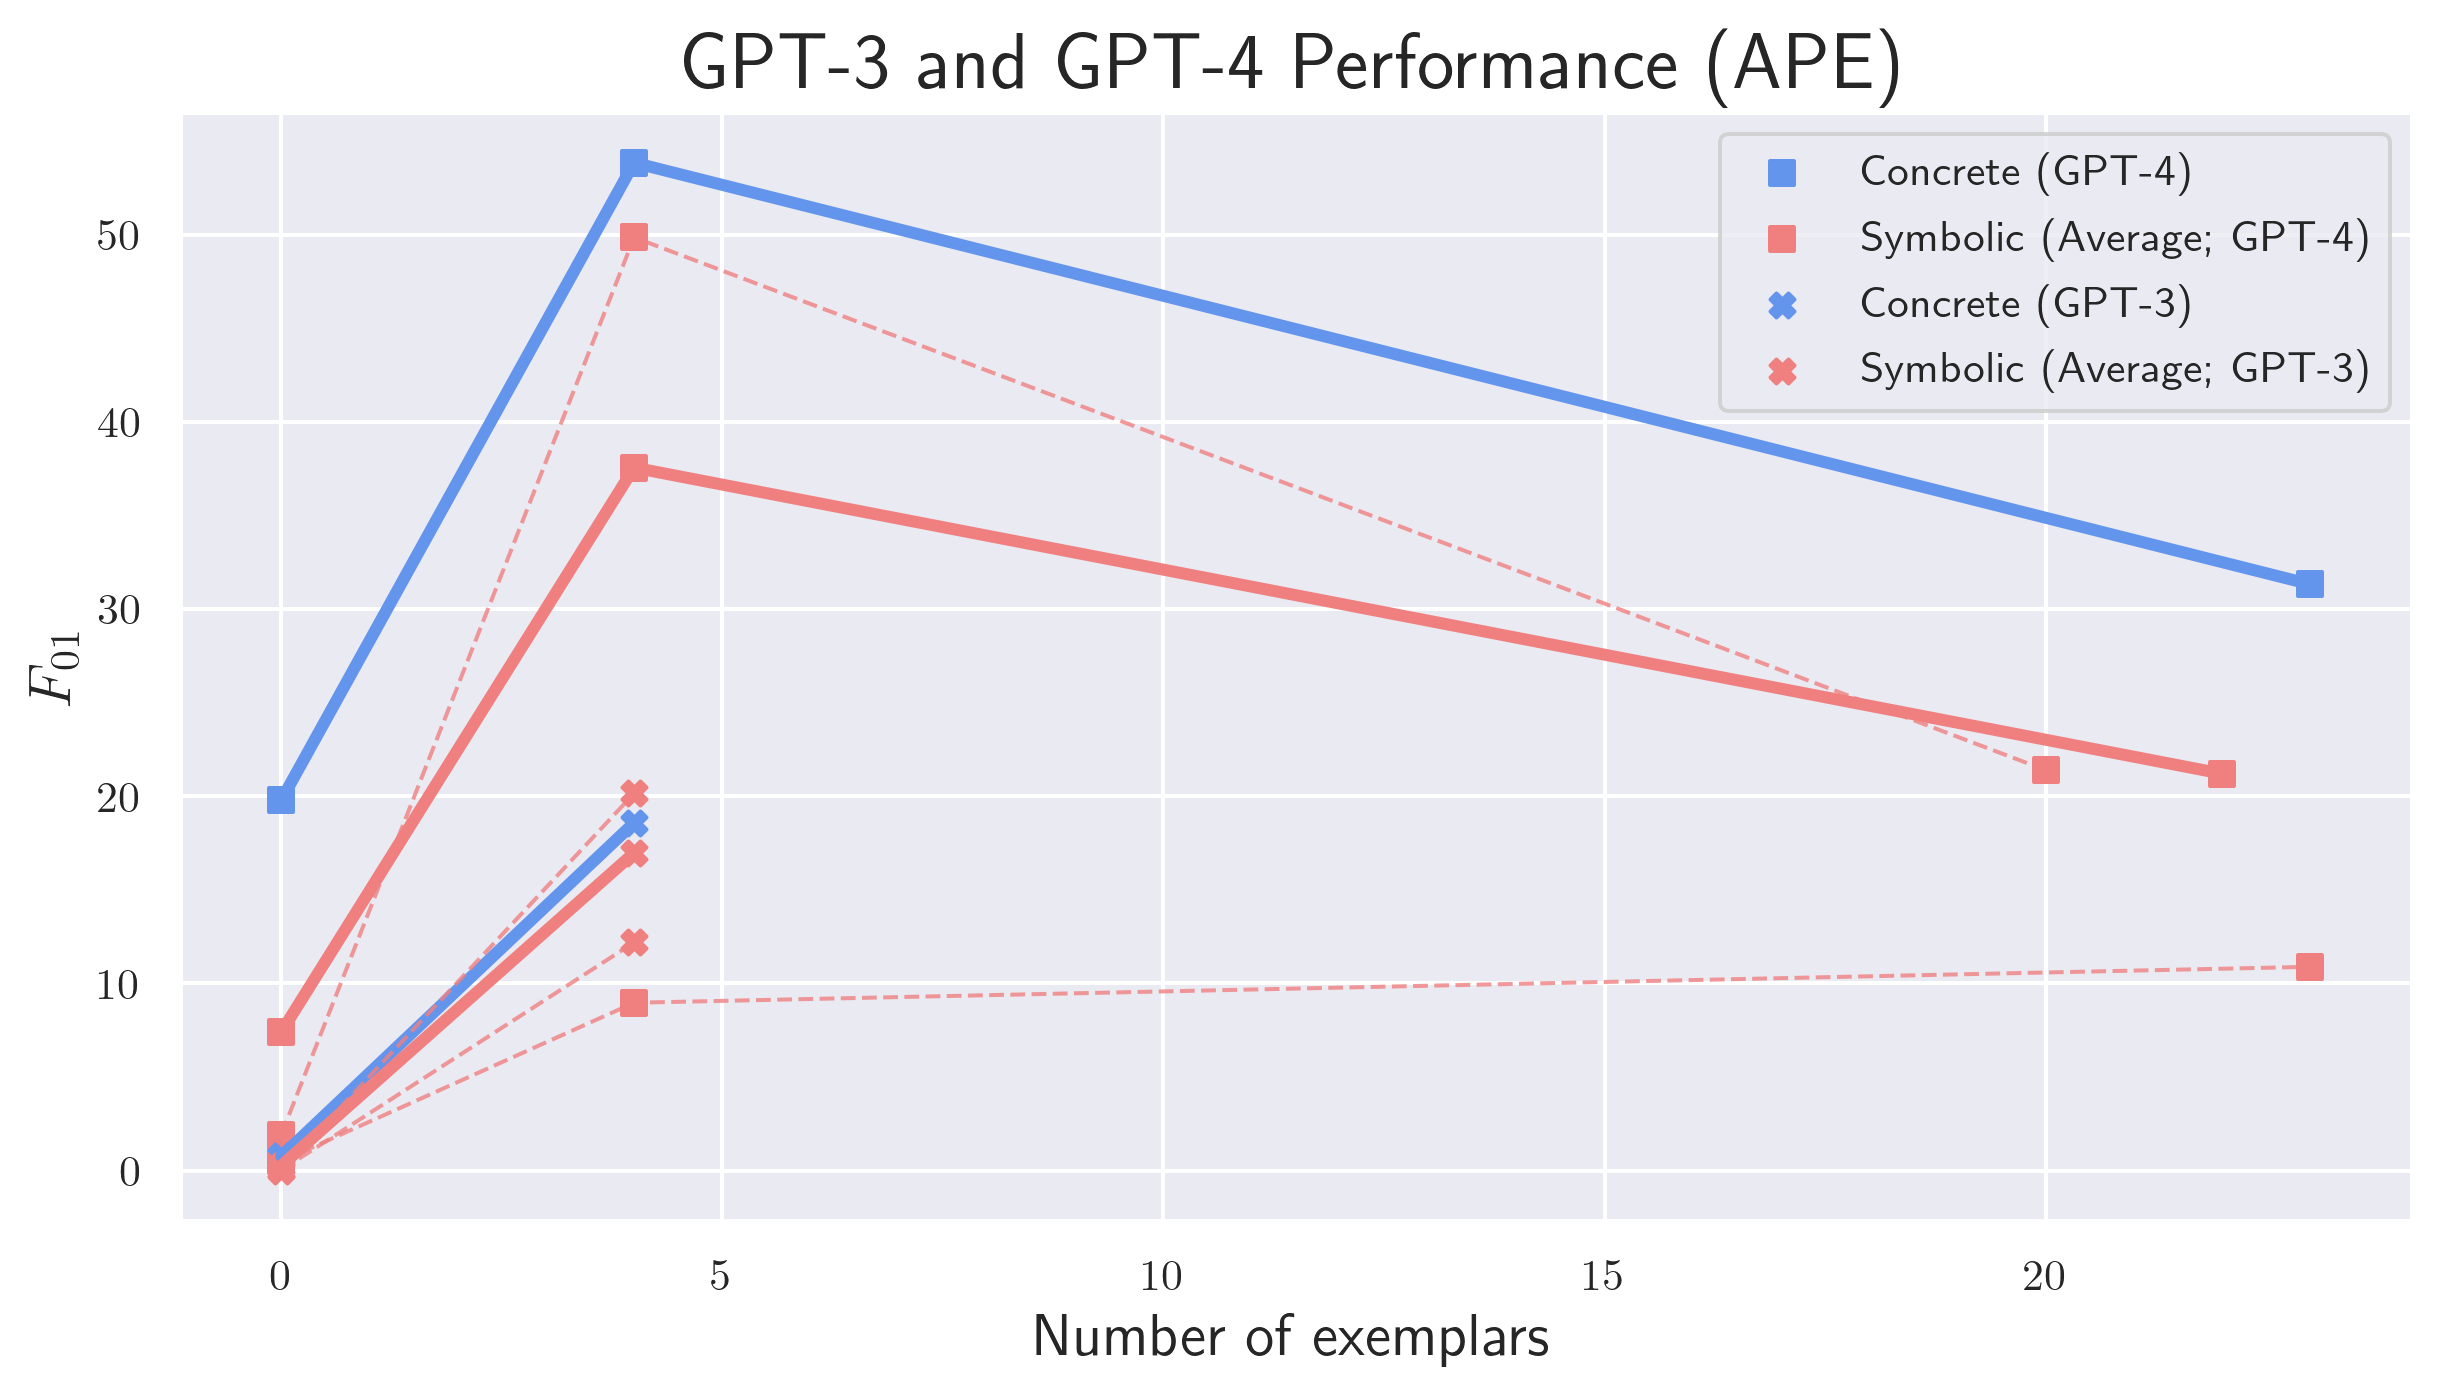

In [17]:
sns.set_theme()
fig = plt.figure(figsize = (10, 5))
base_width = 1
base_alpha = 0.8
avg_weight = 3
avg_alpha = 1.

ix_concrete = 4
ix_symbolic = 2

x = [0, 4, 23]
xkeys = ["0k", "4k", "32k"]

plt.scatter(x, [results_gpt4_ape_start[i][0] for i in xkeys],  marker="s", label="Concrete (GPT-4)",color=default_with_darker_neutral[ix_concrete])
plt.plot(x, [results_gpt4_ape_start[i][0] for i in xkeys], linewidth=avg_weight, alpha=avg_alpha,
         color=default_with_darker_neutral[ix_concrete])

xkeys = ["0k", "4k", "32k"]
# label="Symbolic (no numbers; GPT-4)",
plt.scatter(x, [results_gpt4_ape_symbolic_no_numbers[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [results_gpt4_ape_symbolic_no_numbers[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width, linestyle="dashed", color=default_with_darker_neutral[ix_symbolic])

x = [0, 4, 20]
# label="Symbolic (numbers; GPT-4)",
plt.scatter(x, [results_gpt4_ape_symbolic_numbers[i][0] for i in xkeys], marker="s", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [results_gpt4_ape_symbolic_numbers[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width, linestyle="dashed", color=default_with_darker_neutral[ix_symbolic])

lambda_sum = lambda j: (results_gpt4_ape_start[j][0] + results_gpt4_ape_symbolic_no_numbers[j][0] + results_gpt4_ape_symbolic_numbers[j][0])/3
x = [0, 4, (23 + 23 + 20)/3]
y = [lambda_sum(i) for i in xkeys]
plt.scatter(x, y, marker="s",label="Symbolic (Average; GPT-4)",  color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, y, linewidth=avg_weight, alpha=avg_alpha,
         color=default_with_darker_neutral[ix_symbolic])


# GPT3 -------------------

x = [0, 4]
xkeys = ["0k", "4k"]
plt.scatter(x, [results_gpt3_ape_start[i][0] for i in xkeys], marker="X", label="Concrete (GPT-3)",color=default_with_darker_neutral[ix_concrete])
plt.plot(x, [results_gpt3_ape_start[i][0] for i in xkeys], linewidth=avg_weight, alpha=avg_alpha, color=default_with_darker_neutral[ix_concrete])

x = [0, 4]
# label="Symbolic (no numbers; GPT-3)", 
plt.scatter(x, [results_gpt3_ape_symbolic_no_numbers[i][0] for i in xkeys], marker="X", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [results_gpt3_ape_symbolic_no_numbers[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width, linestyle="dashed", color=default_with_darker_neutral[ix_symbolic])

x = [0, 4]
# label="Symbolic (numbers; GPT-3)", 
plt.scatter(x, [results_gpt3_ape_symbolic_numbers[i][0] for i in xkeys], marker="X", color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, [results_gpt3_ape_symbolic_numbers[i][0] for i in xkeys], alpha=base_alpha,
         linewidth=base_width, linestyle="dashed", color=default_with_darker_neutral[ix_symbolic])

def lambda_sum(j):
    if j == "0k":
        x = results_gpt3_ape_start[j][0] + results_gpt3_ape_symbolic_no_numbers[j][0] + results_gpt3_ape_symbolic_numbers[j][0]
    else:
        x = results_gpt3_ape_start[j][0] + results_gpt3_ape_symbolic_no_numbers[j][0] + results_gpt3_ape_symbolic_numbers[j][0]
    return x/3

xkeys = ["0k", "4k"]
x = [0, 4]
y = [lambda_sum(i) for i in xkeys]
plt.scatter(x, y, marker="X",label="Symbolic (Average; GPT-3)",  color=default_with_darker_neutral[ix_symbolic])
plt.plot(x, y, linewidth=avg_weight, alpha=avg_alpha,
         color=default_with_darker_neutral[ix_symbolic])


plt.title("GPT-3 and GPT-4 Performance (APE)", fontsize=20)
plt.xlabel("Number of exemplars", fontsize=15)
plt.ylabel("$F_{01}$", fontsize=15)
plt.legend()
plt.show()